# Analyzing Backflip data

#### This is an ipython notebook that will walk you through my analysis on the Backflip game ad data
To run this ipython notebook on your own computer, you need to have the following packages installed: 

python, numpy, pandas, scikit-learn, seaborn, matplotlib

## About the data:
"Backflip uses an ad server to display ads in our games. Generally, we cross-promote our own games to the Backflip Audience.You have received 1 month of dummy ad data (in raw format)as well as a key to the report.
Review and analyze the data and note any observations or conclusions you arrive at."

The given data are aggregated data, not user-based data. 
## Goal:
This data contains the information on how each game Ad performes on different game App. I think the key metrics here are the number of impressions, clicks, and conversions. Besides, we can compute the click-through-rate(CTR=clicks/impressions), and conversion rate (CVR=conversions/impressions). 

Ultimately, we want to find out what are the key factors that affect impressions, CTR, CVR. And what can we do to increase those key metrics.


## Process
#### Step1: Data cleaning and preparation (featuring engineering)
1) remove NaN values

2) remove values that does not make sense: e.g., entries with clicks>impressions or conversions>impressions

3) engineer new features: type of device, iphone or ipad

#### Step2: Make plots to get some preliminary insights on the data

#### Step3: Use machine learning methods to find out the key factors that affect impressions, CTR, CVR. 


### Terminologies:

CTR: click-through-rate=clicks/impressions

CVR: conversion rate=conversions/impressions

In [91]:
import pandas as pd
import numpy as np
import re
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns',500)

#
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [92]:
#== read in data
fileNm="dummy_game_ad_data.csv"
df0=pd.read_csv(fileNm)
#== check basic data information
print "%20s %20s %20s %20s"%('column name','# of unique values','# of nulls','# of entries')
for col in df0.columns.tolist():
    print "%20s %20d %20d %20d"%(col,df0[col].unique().size,df0[col].isnull().values.sum(),df0[col].size)


         column name   # of unique values           # of nulls         # of entries
              zoneid                   54                    0                 1000
          creativeid                  447                    0                 1000
           adorderid                  104                    0                 1000
                date                    2                    0                 1000
                 app                   13                    0                 1000
         impressions                  504                    0                 1000
              clicks                  285                    0                 1000
         conversions                   60                    0                 1000
             revenue                   23                    0                 1000
             ad_name                  445                    0                 1000
       campaign_name                  104                    0              

## Step1: Data cleaning and preparation (featuring engineering)
Based on the information above, we can see there are some missing values (3 in ad_size, and 30 in tier). Because the number of missing value is small (at most 33 out of 1000), we can just remove them. 

Besides, in some entries, the number of impression is smaller than clicks or conversions, which does not make physical sense. Therefore, we need to delete those entries.

Another problem is, there are too many different "app name","ad name", and "ad slot name". Many of them are similar to each other. Therefore, I will group those names simply based on their names. Because this data is relatively small and simple, I will simply group them by finding the patterns in names (it's easy and quick). However, in case of large amount of complicate data, one should use NLP to process. 

During the process, I also find an interesting feature I could use, that is, the type of device: iphone or ipad. Most entries have this information directly in the "ad_name","campaign_name", or "ad_slot_name". But some does not, in that case, we can figure out the device based on the size of the ad ("ad_size"). 

In [93]:
#== remove NaN and values that does not make sense
df0=df0[df0['impressions']>df0['clicks']]
df0=df0[df0['impressions']>df0['conversions']]
df1=df0.dropna()

#==== preprocess the data ===== group the features, engineer new features

def renameApp(sIn):
    # initially, there are 13 different 'app' names, but many of them are related, so I will\
    # remove those unimportant words, and so the 'app' can be grouped 
    s=sIn.split(" ")
    sExc=['HD','Free','iPad','iPhone','3','Deluxe','Green','House']
    sOut=""
    for word in s:
        if(word not in sExc):
            sOut+=" %s"%(word)
    return sOut[1:].lower()        

def renameAd(sIn):
    if "_" in sIn: #name format: 'House_LLDXFree_iPhone_Interstitials'
        sOut=sIn.split('_')[1]
        return sOut.lower()
    else: # name format: 'Leaping Leopard Deluxe HD News'
        # remove anything after these words
        sExc1=['iPhone','iPad','(iPad)','HD','Interstitials','Deluxe','Free'] 
        # just remove these words
        sExc2=['House','Ads','-','Gameplay','Lite','News','Banner','New',\
               'Now','Ads-','Retina','Facebook','Millenial','Interstitial',\
               'Admob','Menu','Banners','Inmobi','Backflip','Video']
        sOut=""
        for word in sIn.split(" "):
            if word in sExc1:
                break
            elif word in sExc2:
                continue
            sOut+=" %s"%(word)
        return sOut[1:].lower()
    
def groupAd(sIn):
    if sIn=='treetoppers':
        return 'tree toppers'
    elif sIn=='mm:gh':
        return 'mm gh'
    elif sIn=='bubblepop':
        return 'bubble pop'
    else:
        return sIn

def renameAdSlot(sIn):
    # rename the ad_slot_name information, remove unnecessary information
    sExc=['iPad','(iPad)','iPhone','3G','Leaoping','Leopard','LLD','Free']
    sOut=""
    for word in sIn.split(" "):
        if word in sExc:
            continue
        else:
            sOut +=" %s"%word
    return sOut[1:]    


def findDevice(str1,str2,str3):
    # get info on the device from the ad_name, campain_name, or ad_slot_name
    for sIn in (str1,str2,str3):
        s=re.split(' |_',sIn.lower())
        if('ipad' in s or '(ipad)' in s or 'ipadbanner' in s):
            return 'ipad'
        elif('iphone' in s or '(iphone)' in s or 'iphonebanner' in s):
            return 'iphone'
    return 'unKnown'

    
def getWidth(sIn):
    # get the width and height of the ad from the 'ad_size'
    return int(re.split('x|X',sIn)[0])
def getHeight(sIn):
    return int(re.split('x|X',sIn)[1])

#
df1.loc[:,'appNmGp']=df1['app'].apply(renameApp)
df1.loc[:,'adNmGp']=df1['campaign_name'].apply(renameAd).apply(groupAd)
df1.loc[:,'adSlotNmGp']=df1['ad_slot_name'].apply(renameAdSlot)                       
df1.loc[:,'deviceNm']=df1.apply(lambda row: findDevice(row['ad_name'],row['campaign_name'],row['ad_slot_name']),axis=1)
df1.loc[:,'adWidth']=df1['ad_size'].apply(getWidth)
df1.loc[:,'adHeight']=df1['ad_size'].apply(getHeight)
#
#==== fill in the missing device information based on the device info obtained from last step
#-- i did make sure that these two lists have no overlap
ipadSizeLst=df1[df1['deviceNm']=='ipad']['ad_size'].unique()
iphoneSizeLst=df1[df1['deviceNm']=='iphone']['ad_size'].unique()
def findDeviceMissing(ipadSizeLst,iphoneSizeLst,str1,str2):
    # str1 is the given deviceNm from previous step; str2 is the ad_size column in the raw data
    str2=str2.lower()
    if str1=='unKnown':
        if(str2 in ipadSizeLst):
            return 'ipad'
        elif(str2 in iphoneSizeLst):
            return 'iphone'
        else:
            return 'unKnown'
    else:
        return str1
#
df1.loc[:,'deviceNm']=df1.apply(lambda row: findDeviceMissing(ipadSizeLst,iphoneSizeLst,row['deviceNm'],row['ad_size']),axis=1)
#
print "\nGrouped app names({0}):\n{1}".format(df1['appNmGp'].unique().size,df1['appNmGp'].unique())
print "\nGrouped Ad names({0}):\n{1}".format(df1['adNmGp'].unique().size, df1['adNmGp'].unique())
print "\nGrouped Ad Slot names({0}):\n{1}".format(df1['adSlotNmGp'].unique().size,df1['adSlotNmGp'].unique())

#


Grouped app names(4):
['leaping leopard' 'mop man' 'backflip puzzle match' 'tower warriors']

Grouped Ad names(26):
['lldxfree' 'mopman2' 'tw' 'puzzle match' 'outfit7' 'tree toppers'
 'goblin legion campaign' 'uncapped' 'cybermonsters' 'walrusattack'
 'mm2icontest' 'raffle riders' 'leaping leopard' 'mop man' 'mm gh' 'poker'
 'bubble pop' 'twhd' 'foosball' 'backflip' 'phopod' 'kangaroos' 'nn3lite'
 'remembird' 'newsmodules' 'allgames']

Grouped Ad Slot names(7):
['Startup Interstitial' 'Gameplay' 'Gameplay Interstitial'
 'Gameplay Banner' 'Menu Banner' 'Menu' 'News']


## Step2: Make plots to get some preliminary insights on the data
We can make tons of figures to look at, here I only presnet you some interesting ones.

In [94]:
#==== functions for grouping data and making plots 
from matplotlib.colors import SymLogNorm
#--use log scale to make plot, to display changes across disparate scales.

#--- groupby the data and compute click-through-rate and conversion-rate ----
def groupbyDf(df,colnm):
    colNmOutLst=['impressions','clicks','conversions','revenue']
    dfOut=df.groupby(colnm).sum()[colNmOutLst]
    # compute click through rate CTR=clicks/impression*100, conversion rate conversion/imporession*100
    dfOut.loc[:,'CTR']=100.*dfOut['clicks']/dfOut['impressions']
    dfOut.loc[:,'CVR']=100.*dfOut['conversions']/dfOut['impressions']
    return dfOut

#--- plot histograms for impressions & clicks & conversions & CTR & etc, plot single-para histogram
def plotHist(dfPlot,wid,hei,fs,rotAng):
    #
    plt.figure(figsize=(wid,hei))
    dfPlot['impressions'].plot(kind='bar',title='impressions',rot=rotAng,fontsize=fs) 
    #plt.figure(figsize=(wid,hei))
    #dfPlot['clicks'].plot(kind='bar',title='clicks',rot=rotAng,fontsize=fs)
    #plt.figure(figsize=(wid,hei))
    #dfPlot['conversions'].plot(kind='bar',title='conversions',rot=rotAng,fontsize=fs)
    plt.figure(figsize=(wid,hei))
    dfPlot['CTR'].plot(kind='bar',title='click through rate(%)',rot=rotAng,fontsize=fs,alpha=0.6,color='red')
    #plt.figure(figsize=(wid,hei))
    #dfPlot['CVR'].plot(kind='bar',title='conversion rate(%)',rot=rotAng,fontsize=fs,alpha=0.6,color='red')
    
#--- plot histograms for impressions & clicks & conversions & CTR & etc. Plot multi-para histograms    
def plotHist2Gp(df,wid,hei,fs,rotAng,logY):
    #wid=15
    #hei=5
    #logY=True
    df['impressions'].unstack().plot(rot=rotAng,figsize=(wid,hei),kind='bar',fontsize=fs,logy=logY,title='number of impression')
    #df['clicks'].unstack().plot(rot=rotAng,figsize=(wid,hei),kind='bar',fontsize=fs,logy=logY,title='clicks')
    #df['conversions'].unstack().plot(rot=rotAng,figsize=(wid,hei),kind='bar',fontsize=fs,logy=logY,title='conversions')
    df['CTR'].unstack().plot(rot=rotAng,figsize=(wid,hei),kind='bar',fontsize=fs,logy=logY,title='click through rate(%)')
    df['CVR'].unstack().plot(rot=rotAng,figsize=(wid,hei),kind='bar',fontsize=fs,logy=logY,title='conversion rate(%)')
    

def plotHeatmap(dfIn,outColNm,flagRatio,ttNm,linthresh=0.01,cmap='Spectral_r',xlabel='game Ad name',ylabel='game App name'):
    plt.figure(figsize=(18,3))
    #dfIn=groupbyDf(df1,['appNmGp','adNmGp'])
    dfPlot=dfIn[outColNm].unstack()
    if(flagRatio==0): 
        # this summation can only applied to numbers, not ratios; 
        # summation of two CTR does not make sense. 
        # should sum the clicks and impressions and then compute ratio
        dfPlot.loc[:,'SUM_OVER_AD']=dfPlot.sum(axis=1) # sum over y axis
        dfPlot.loc['SUM_OVER_APP',:]=dfPlot.sum(axis=0)  
    elif(outColNm=='CTR'):
        dfPlot.loc[:,'CTR_SUM_OVER_AD']=100.*dfIn['clicks'].unstack().sum(axis=1)/dfIn['impressions'].unstack().sum(axis=1)
        dfPlot.loc['CTR_SUM_OVER_APP',:]=100.*dfIn['clicks'].unstack().sum(axis=0)/dfIn['impressions'].unstack().sum(axis=0)
    elif(outColNm=='CVR'):
        dfPlot.loc[:,'CVR_SUM_OVER_AD']=100.*dfIn['conversions'].unstack().sum(axis=1)/dfIn['impressions'].unstack().sum(axis=1)
        dfPlot.loc['CVR_SUM_OVER_APP',:]=100.*dfIn['conversions'].unstack().sum(axis=0)/dfIn['impressions'].unstack().sum(axis=0)
    sns.heatmap(dfPlot,cmap=cmap,norm=SymLogNorm(linthresh=linthresh, linscale=0.03)) # only the linthresh changes the output color
    plt.yticks(rotation=0,fontsize=18)
    plt.xticks(rotation=80,fontsize=18)
    plt.xlabel(xlabel,fontsize=20)
    plt.ylabel(ylabel,fontsize=20)
    plt.title(ttNm,fontsize=25)    

In [95]:
#==== group data
dfAppNm=groupbyDf(df1,'appNmGp')
dfAdNm=groupbyDf(df1,'adNmGp')
dfDevice=groupbyDf(df1,'deviceNm')
dfDestType=groupbyDf(df1,'destination_type')
dfTier=groupbyDf(df1,'tier')
dfAdType=groupbyDf(df1,'ad_type')
dfAdSlotNmGp=groupbyDf(df1,'adSlotNmGp')
dfDate=groupbyDf(df1,'date')



dfAdApp=groupbyDf(df1,['adNmGp','appNmGp'])
dfAppDevice=groupbyDf(df1,['appNmGp','deviceNm'])
dfAppDate=groupbyDf(df1,['appNmGp','date'])
dfTierApp=groupbyDf(df1,['tier','appNmGp'])
dfSlotApp=groupbyDf(df1,['adSlotNmGp','appNmGp'])
dfSlotAd=groupbyDf(df1,['adSlotNmGp','adNmGp'])
dfDeviceApp=groupbyDf(df1,['deviceNm','appNmGp'])
dfDeviceAd=groupbyDf(df1,['deviceNm','adNmGp'])
dfTierSlot=groupbyDf(df1,['tier','adSlotNmGp'])

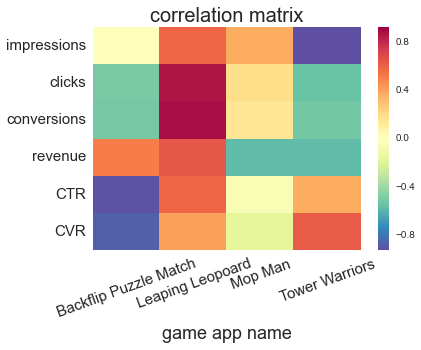

In [96]:
#=== plot correlation between key metrics (impresseion, CTR etc.) and app names
dfslice=pd.get_dummies(dfAppNm.reset_index()).corr().iloc[0:6,6:]
sns.heatmap(dfslice,xticklabels=\
            ['Backflip Puzzle Match','Leaping Leopoard','Mop Man','Tower Warriors'],cmap='Spectral_r')
plt.yticks(rotation=0,fontsize=15)
plt.xticks(rotation=20,fontsize=15)
plt.xlabel('game app name',fontsize=18)
plt.title('correlation matrix',fontsize=20)

Based on the correlation heatmap above, we can see that "Leaping Leopard" and "Mop Man" have the most impressions, indicating they have lots of users. The CTR (click through rate) and CVR (conversion rate) is high for "Leaping Leopard", and medium for "Mop Man". 

Although "Tower Warriors" does not have lots of user (low impressions), the users who playes this game likes the Ads on it, and have relatively high CTR (click through rate) and CVR (conversion rate).

On the other hand, "Backflip Puzzle Match" does not have much users, and those users do not like Ads. 

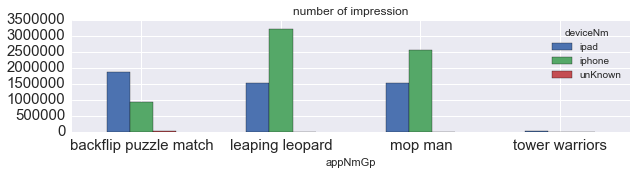

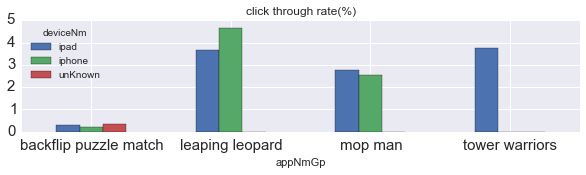

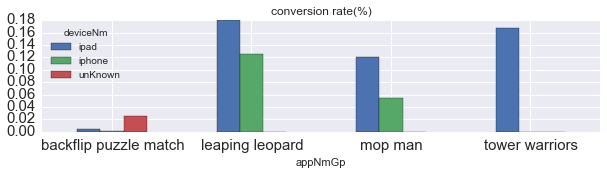

In [97]:
#=== plot histograms
plotHist2Gp(dfAppDevice,10,2,15,0,False)


The histograms above show how impressions, click through rate, conversion rate change with app_name and device_name, we can find something interesting out of them:

1) People like playing "Leaping Leopard" and "Mop Man" on iphone, but like playing "Puzzle Match" on ipad. Besides, "Tower Warriors" is an ipad game, there are no iphone users.

2) Overall, there are more iphone players than ipad players. However, both the click through rate (CTR) and conversion rate (CVR) are higher on ipad. ipad players like Ads more!


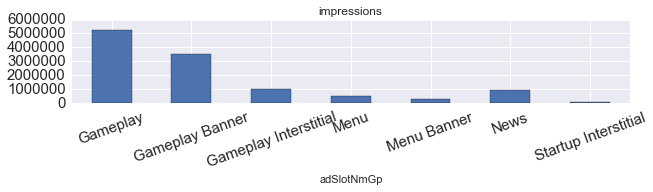

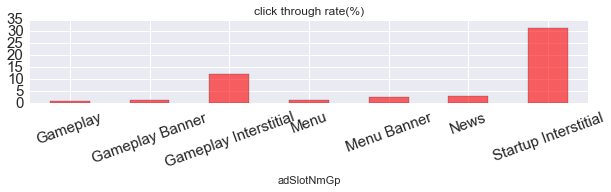

In [98]:
plotHist(dfAdSlotNmGp,10,1.5,15,20)

The histograms above show how impression and click through rate change with ad slot name, we can see that: 

1) Most of the ads were displayed during gameplay (high impressions)

2) Both "Gameplay Interstitial" and "Startup Intersitial" slots have high click through rate, those two are good slots for displaying ads!


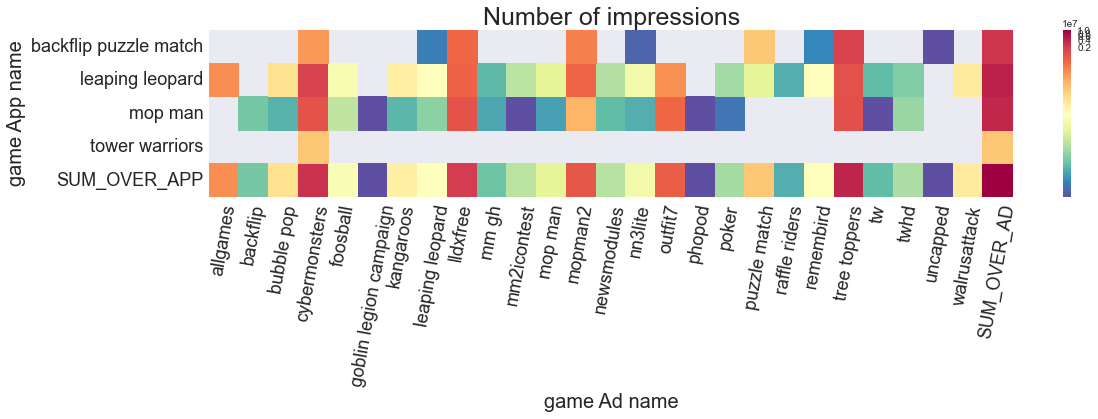

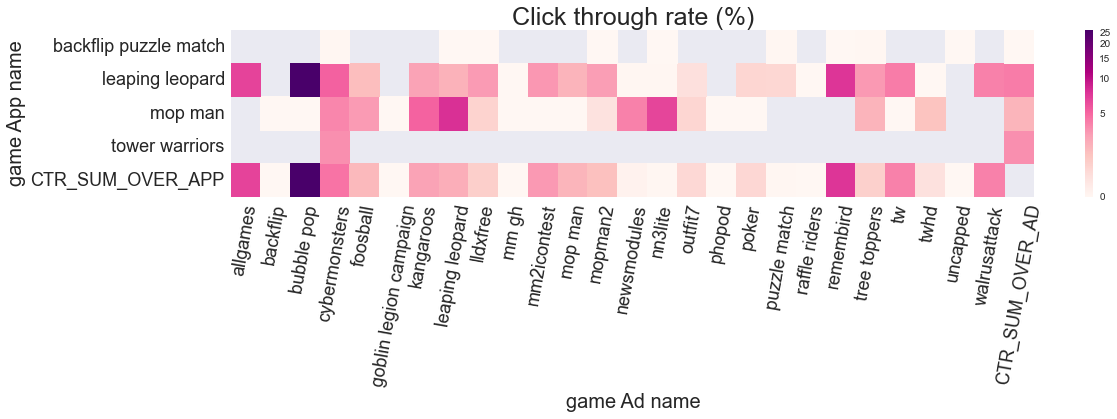

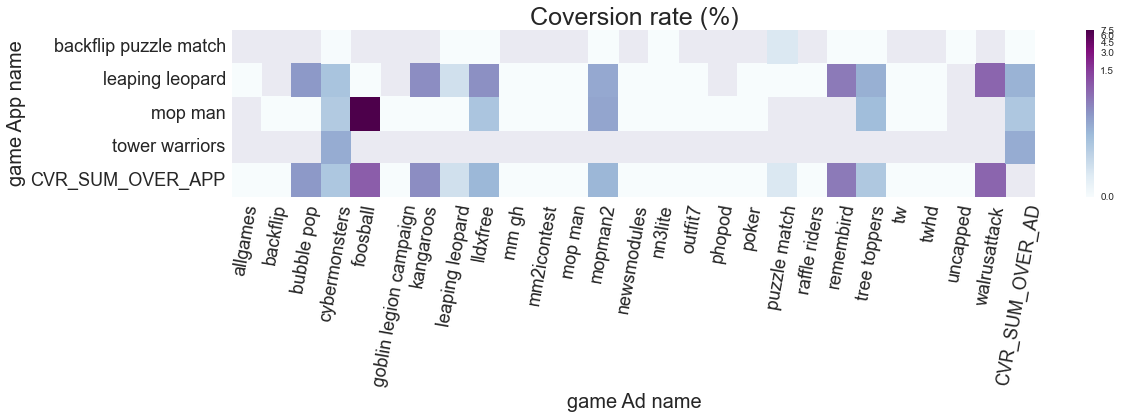

In [99]:
#=== plot heatmaps
dfAppAd=groupbyDf(df1,['appNmGp','adNmGp'])
plotHeatmap(dfAppAd,'impressions',0,ttNm='Number of impressions')
plotHeatmap(dfAppAd,'CTR',1,ttNm='Click through rate (%)',linthresh=1,cmap='RdPu') 
plotHeatmap(dfAppAd,'CVR',1,ttNm='Coversion rate (%)',linthresh=0.01,cmap='BuPu') 

The heatmaps above represent how impressions, click through rate, and coversion rate change with app_name and ad_name. 

1) The upper figure (impressions) shows that most of the traffic come from the "Leaping Leopard" and "Mop Man" apps. "Tower warriors" app has only one ads, "cybermonster". Besides, the "cybermonsters", "lldxfree", "mop man2", "tree toppers" are the mostly advertised game ads in that 1 month. 

2) The middle figure (click through rate, i.e., CTR) shows that game ads for "bubble pop", "remem bird", and "allgames"(???) have the highest CTR. People like those ads. 

Besides, for the same ads, their CTR varies from app to app, player of "Leaping Leopard" like the ad for "bubble pop"!

3) The bottom figure (conversion rate, i.e., CVR) shows that ads for "foosball" (??"football"??), "walrus attack", and "remem bird" have the highest CVR. For some reasons, people like those ads, and want to install them. 

Besides, "Mop Man" is a better place to advertise "foosball", and "Leaping Leopard" is a better place to advertise "bubble pop" and "kangaroos".  


## Step3: Use machine learning methods to find out the key factors that affect impressions, CTR, CVR. 
Based on the figures above, we can find that there are some key factors (e.g. device, ad slot name, ad name) that affect the final impressions, CTR, CVR. Next, we will use machine learning method to find out what factors are important, and how important are they. 

The math problem we want to solve is: Build a model to fit the Y value (impressions, CTR, or CVR), based on given X values (data features: 'ad_format','destination_type','tier','ad_type','app name','ad name','device', etc.)


At first, this look like a regression problem, bacause the values we want to predict (impressions, CTR, or CVR) are all qulitative values. However, when you look at the distribution of those values, they do not have normal distribution, and they are highly skewed to the value of 0. In this case, regression method that is sensitive to outliers will perform badly. (I tried random forest regression on this problem, and it doesn't work well, the output score is ~0.4 or even < 0; we want the score to be close to 1)

Therefore, we need to simplify the problem. One approach is labeling the data, and change it to a classification problem.

###### Label the data: 
I label the impressions, CTR, or CVR into two categories, 'high'(1) or 'low'(0), based on given threshold. In this analysis, I simply choose the threshold based on the distribution of data and my own experience (acutally 'guess'). In real case, we need to choose this threshold based on domain knowledge, and with the help from the marketing/business teams.

###### Classify the data:
With the labeling, we can then build a model to classify the data. I will use random forest method, and look at the feature importance. 

But before that, we need to change all those categorical features into dummy variables.


In [100]:
#=== prepare the data, 
#--- choose features to use, aggregate data, label data, create dummy variables for categorical features
def labelData(criteria,num):
    #--- label data based on give criteria, 
    #--- currently, multi-class is not supported, only binary classification
    if num>=criteria:
        return 1
    else:
        return 0

#-- choose features to use
featureNmLst=['ad_format','destination_type','tier','ad_type','appNmGp',\
         'adNmGp','adSlotNmGp','deviceNm']#,'adWidth','adHeight']
colNmOutLst=['impressions','clicks','conversions']

#-- aggregate data 
df1gp=df1.groupby(featureNmLst,as_index=False)[colNmOutLst]
df2=df1gp.sum()
df2.loc[:,'CTR']=100.*df2['clicks']/df2['impressions']
df2.loc[:,'CVR']=100.*df2['conversions']/df2['impressions']

#-- label data
df2.loc[:,'labelCTR']=df2.apply(lambda row: labelData(10,row['CTR']),axis=1)  
df2.loc[:,'labelCVR']=df2.apply(lambda row: labelData(1.,row['CVR']),axis=1) 
df2.loc[:,'labelImpressions']=df2.apply(lambda row: labelData(1e4,row['impressions']),axis=1) 

#-- create dummy variable for categorical features
df3=pd.get_dummies(df2[featureNmLst]) 
#-- 
X=df3.values
featureNm=df3.columns
Y=df2


In [101]:
#-- count the number of each labels
print df2.groupby('labelCTR').count().icol(1)
print df2.groupby('labelCVR').count().icol(1)
print df2.groupby('labelImpressions').count().icol(1)

labelCTR
0    233
1     48
Name: destination_type, dtype: int64
labelCVR
0    245
1     36
Name: destination_type, dtype: int64
labelImpressions
0    209
1     72
Name: destination_type, dtype: int64


In [102]:
#=== functions to perform machin learning methods

from sklearn.cross_validation import train_test_split 
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.grid_search import GridSearchCV

def doRandomForestCla(X,Y,N,title,flagPlot=1):
    #--- random forest classification
    flagGridSearch=0 # do gird serach or not
    if(flagGridSearch==1):      
        #--do a grid serach to find the optimal parameter for RF
        rfc = GridSearchCV(RandomForestClassifier(), param_grid = \
          {'n_estimators': [10,20,50,100,200,500], \
           'max_features': ['auto','sqrt','log2'], \
           'min_samples_leaf':[1,2,3,5] }, \
            scoring='roc_auc', cv=4)
        rfc.fit(X,Y)
        #- the best RF estimator
        forest=rfc.best_estimator_ 
        score=rfc.best_score_
    else:    
        #-- use the parameters got from GirdSearch
        rfc=RandomForestClassifier(\
               max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=2,
               min_samples_split=2, n_estimators=20, n_jobs=1, 
                                  )
        rfc.fit(X,Y)
        forest=rfc
        score=rfc.score(X,Y)
    
    if(flagPlot==1):
        plotFeatureImp(X,N,forest,title)
    return forest,score

def plotFeatureImp(X,N,forest,title):        
        #--- make a plot for the figure importance (the N most important features)
        N=min(N,X.shape[1]) # N cannot be larger than # of features
        #- feature importance, and error of feature importance
        featureImp=forest.feature_importances_
        featureStd=np.std([tree.feature_importances_ \
                           for tree in forest.estimators_],axis=0)
        #- descendingly order the feature importance
        indices=np.argsort(featureImp)[::-1] 

        plt.figure(figsize=(10,4))
        plt.title("Feature Importance for %s"%title,fontsize=20)
        #plt.bar(range(N),featureImp[indices][0:N]\
        #        ,color='r',yerr=featureStd[indices][0:N],align='center')
        #plt.xticks(range(N),featureNm[indices[0:N]],rotation=80,fontsize=15)
        plt.barh(range(N)[::-1],featureImp[indices][0:N]\
               ,color='r',xerr=featureStd[indices][0:N],align='center')
        plt.yticks(range(N)[::-1],featureNm[indices[0:N]],rotation=0,fontsize=15)
        
#

In [103]:
#=== run the machine learning methods and plot the feature importance
#forestLabImpr,scoreLabImpr=doRandomForestCla(X,Y.labelImpressions,5,'Impressions')
#print "Score=",scoreLabImpr

Score= 0.946619217082


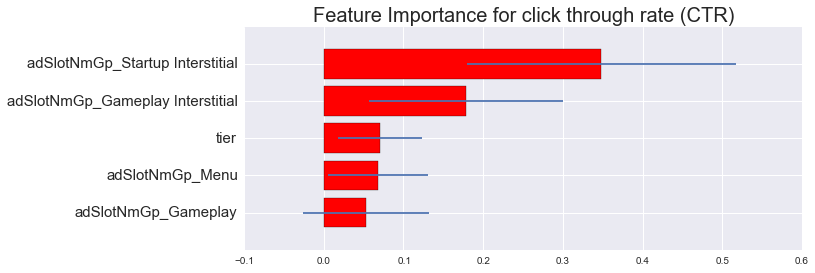

In [104]:
forestLabCTR,scoreLabCTR=doRandomForestCla(X,Y.labelCTR,5,'click through rate (CTR)')
print "Score=",scoreLabCTR


Score= 0.946619217082


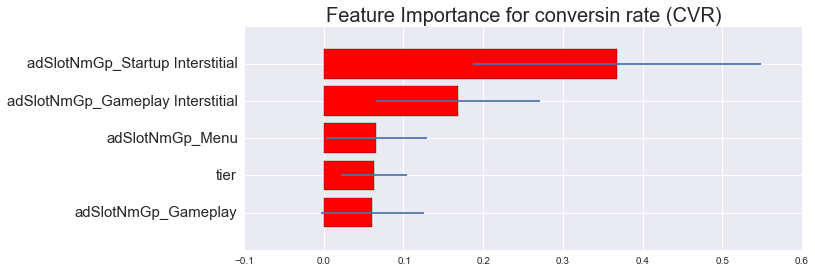

In [105]:
forestLabCVR,scoreLabCVR=doRandomForestCla(X,Y.labelCTR,5,'conversin rate (CVR)')
print "Score=",scoreLabCVR

The figures above shows the feature importance results from the random forest classifier, the blue bars indicate the corresponding errors. 

For both click through rate (CTR), and conversion rate (CVR), the 'ad slot type' and 'tier' are the most important features. 

This reconfirm our previous finding: ads that were displayed during "startup interstitial" have very high CTR and CVR. And it is understandable/expected that 'tier' is important. Tier represetnts priority of the ad, the higher the priority of the ad, the higher the CTR and CVR are.

We can try to put more ad during "startup interstitial", and this may help increasing the CTR and CVR. 


# Findings and actionable insights:

#### 1) About the game app
Game app "Leaping Leopard" and "Mop Man" have lots of users, they are good at getting traffic or user awareness. Therefore, they could be good for ads that are charged by number of impressions (CPM). 

During this 1 month data, the game app "Tower Warriors" advertises only one game ad "cybermonster", and that ad works quite well. The overall click through rate (CVT) and conversion rate (CVR) are high and comparable to that of "Leaping Leopard". However, the number of users for that game is not large. But still, could try to put more ads on that app, this app seems like a good place to display ads. 

The game app "Backflip Puzzle Match" is not a good place to display any ads other than "Puzzle match". Users there do not like ads, they are so focused on the puzzle game. 

#### 2) About the device
Most users play games on iphone. However, both the click through rate (CTR) and conversion rate (CVR) are higher on ipad. ipad users like Ads more than iphone users! 

Maybe the ads show up nicer on ipad (larger size), and users playing with ipad are in a more comfortable enviroment such that they have more time to try other games. Maybe we need different marketing/bussiness strategies for iphone ads and ipad ads?


#### 3) About the ad slot
Most of the ads were displayed during "Gameplay" slot. However, both the click through rate (CTR) and conversion rate (CVR) are higher for ads displayed during "Gameplay Interstitial" and "Startup Interstitial". Should try to move more ads to those two slots.

#### 4) About the advertised games

The "cybermonsters", "lldxfree", "mop man2", "tree toppers" are the mostly advertised (high impressions) game ads in that 1 month, and they all do okay in terms of conversion rate (CVR). 

The following games were not highly advertised (low impressions), but have relatively high CVR. Therefore, could try to put more effort on them in the future.
They are "foosball", "walrus attack", "remem bird", "bubble pop" and "kangaroos"



# Next steps:

All the data are agregated data, and has no user information. If we have some user-based data, like whether a user clicked on an ad (or installed an app) or not, then we can do something more user-based. Analyzing what type of ads does each user like, and try to recommend them personalized ads.

It's a pitty that the date information in this dataset is not corret, otherwise, there would be some interesting time-dependent patterns I can analyze. For example, all those impression, click, conersions are probably depend on day of week. 

At last, after aggregation, the number of data is relatively small. And because most features are categorical, our feature space is large (after grouping all those ad_name, app_name, ad_slot_name, and creating dummy variables for those categorial features, I have 53 feature in total). Therefore, the machine learning model probably have high variance. More data would be helpful in building better models. 
